In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import utils
from torch.utils.data import DataLoader

from Flow2D import Flow2D
from dataset import SwissRollDataset
from plot import plot_results_flow_2D

In [2]:
# Device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [3]:
# Hyperparameters
NUM_EPOCHS = 500
BATCH_SIZE = 512
LEARNING_RATE = 1e-3

**Generating the synthetic dataset**

The true (unknown) data distribution

In [4]:
# Data distribution:
dataset = SwissRollDataset(num_samples=10000)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

**Creating a model**

Model transforms the data distribution (unknown) to Uniform distribution.

In [6]:
# Model
model = Flow2D().to(device)
# model = torch.load("./weights/epoch_50_FLOW2D.pth", map_location=device)

# Optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

Visualizing model's performance before training

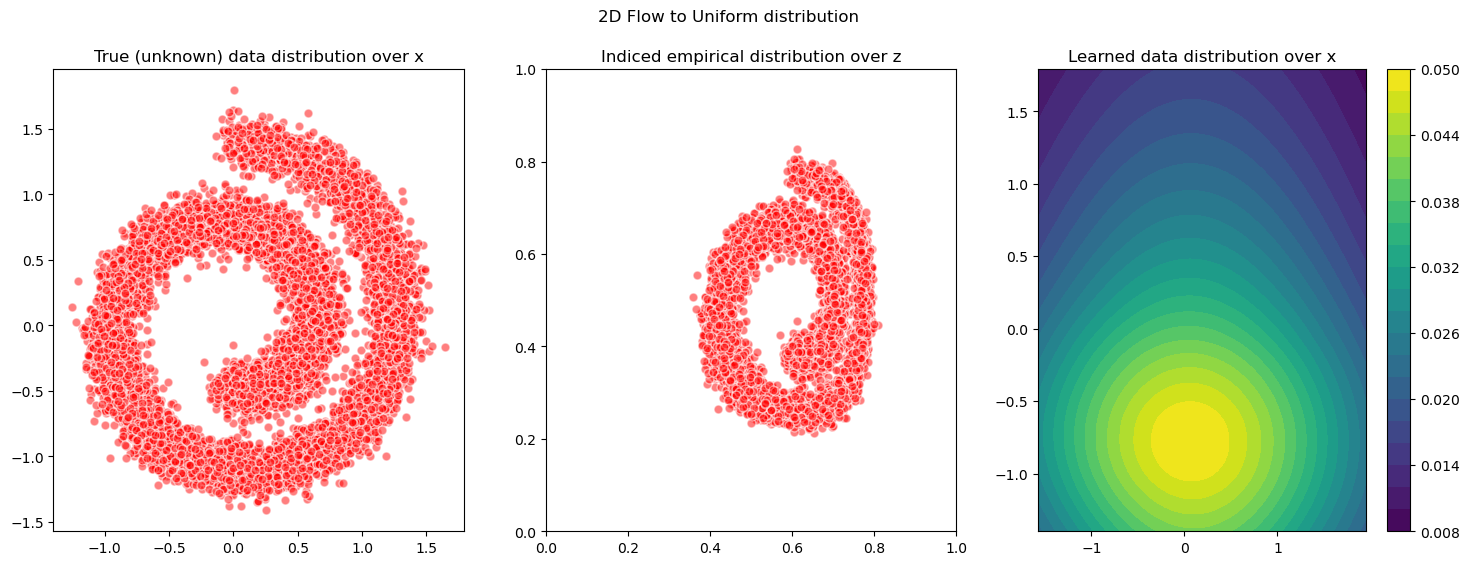

In [7]:
data = dataset.data.to(device)
_, (z1, z2) = model(dataset.data.to(device))
transformed_data = torch.cat([z1, z2], dim=1)
plot_results_flow_2D(data, transformed_data, model, device)

**Training the model**

In [8]:
losses = []

In [9]:
# Training
for epoch in range(NUM_EPOCHS):
    avg_loss = []
    for batch_idx, data_points in enumerate(data_loader):
        # Data gymnastics
        data_points = data_points.to(device)

        # Loss
        loss = model.get_loss(data_points)
        avg_loss.append(loss.item())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Making an update
        optimizer.step()

    avg_loss = torch.mean(torch.tensor(avg_loss))
    if epoch % 10 == 0:
        print('Epoch %d\t Loss=%.5f' % (epoch, avg_loss))
    if epoch % 50 == 0:
        torch.save(model, f'./weights/epoch_{epoch}_FLOW2D.pth')
    losses.append(avg_loss)

Epoch 0	 Loss=3.41580
Epoch 10	 Loss=2.51691
Epoch 20	 Loss=2.22704
Epoch 30	 Loss=1.97939
Epoch 40	 Loss=1.80003
Epoch 50	 Loss=1.66428
Epoch 60	 Loss=1.57675
Epoch 70	 Loss=1.50003
Epoch 80	 Loss=1.45246
Epoch 90	 Loss=1.43235
Epoch 100	 Loss=1.41169
Epoch 110	 Loss=1.40338
Epoch 120	 Loss=1.39613
Epoch 130	 Loss=1.39296
Epoch 140	 Loss=1.38799
Epoch 150	 Loss=1.38479
Epoch 160	 Loss=1.38444
Epoch 170	 Loss=1.37794
Epoch 180	 Loss=1.38163
Epoch 190	 Loss=1.37501
Epoch 200	 Loss=1.37988
Epoch 210	 Loss=1.37310
Epoch 220	 Loss=1.37149
Epoch 230	 Loss=1.37237
Epoch 240	 Loss=1.37345
Epoch 250	 Loss=1.37271
Epoch 260	 Loss=1.36891
Epoch 270	 Loss=1.36904
Epoch 280	 Loss=1.36775
Epoch 290	 Loss=1.36570
Epoch 300	 Loss=1.36489
Epoch 310	 Loss=1.36618
Epoch 320	 Loss=1.36353
Epoch 330	 Loss=1.36051
Epoch 340	 Loss=1.35870
Epoch 350	 Loss=1.34517
Epoch 360	 Loss=1.33163
Epoch 370	 Loss=1.31939
Epoch 380	 Loss=1.31498
Epoch 390	 Loss=1.31204
Epoch 400	 Loss=1.30956
Epoch 410	 Loss=1.31068
Epo

Visualizing model's performance after training

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt


def plot_results_flow_2D(dataset, transformed_dataset, model, device):
    model.eval()
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
    
    # 1) Plotting the data distribution over x
    dataset = dataset.cpu().detach().numpy()
    ax[0].scatter(*(dataset.T), alpha=0.5, color='red', edgecolor='white', s=40)
    ax[0].set_title("True (unknown) data distribution over x")
    x_start, x_end = ax[0].get_xlim()
    y_start, y_end = ax[0].get_ylim()

    # 2) Plotting the transformed data distribution over z
    transformed_dataset = transformed_dataset.cpu().detach().numpy()
    ax[1].scatter(*(transformed_dataset.T), alpha=0.5, color='red', edgecolor='white', s=40)
    ax[1].set_xlim(0, 1)
    ax[1].set_ylim(0, 1)
    ax[1].set_title("Indiced empirical distribution over z")

    # 3) Plotting the learned input distribution

    # -> Create a meshgrid for the domain in torch
    x = torch.linspace(x_start, x_end, 100)
    y = torch.linspace(y_start, y_end, 100)
    X, Y = torch.meshgrid(x, y, indexing='ij')

    # -> Flatten X and Y to create a batch of (x, y) pairs
    X_flat = X.flatten().unsqueeze(dim=1)
    Y_flat = Y.flatten().unsqueeze(dim=1)
    XY_batch = torch.cat([X_flat, Y_flat], dim=1)  # Creates tensor of size (batch, 2)

    # -> Computing the values of density function
    XY_batch = XY_batch.to(device)
    Z = model.log_likelihood(XY_batch)

    # -> Prepare for plotting
    x = x.numpy()
    y = y.numpy()
    Z_grid = Z.view(X.size()).cpu().detach().numpy()

    contourf_output = ax[2].contourf(y, x, np.exp(Z_grid), levels=20, cmap='viridis')
    fig.colorbar(contourf_output, ax=ax[2])
    ax[2].set_title("Learned data distribution over x")

    fig.suptitle("2D Flow to Uniform distribution")
    plt.show()
    print("hee")
    model.train()

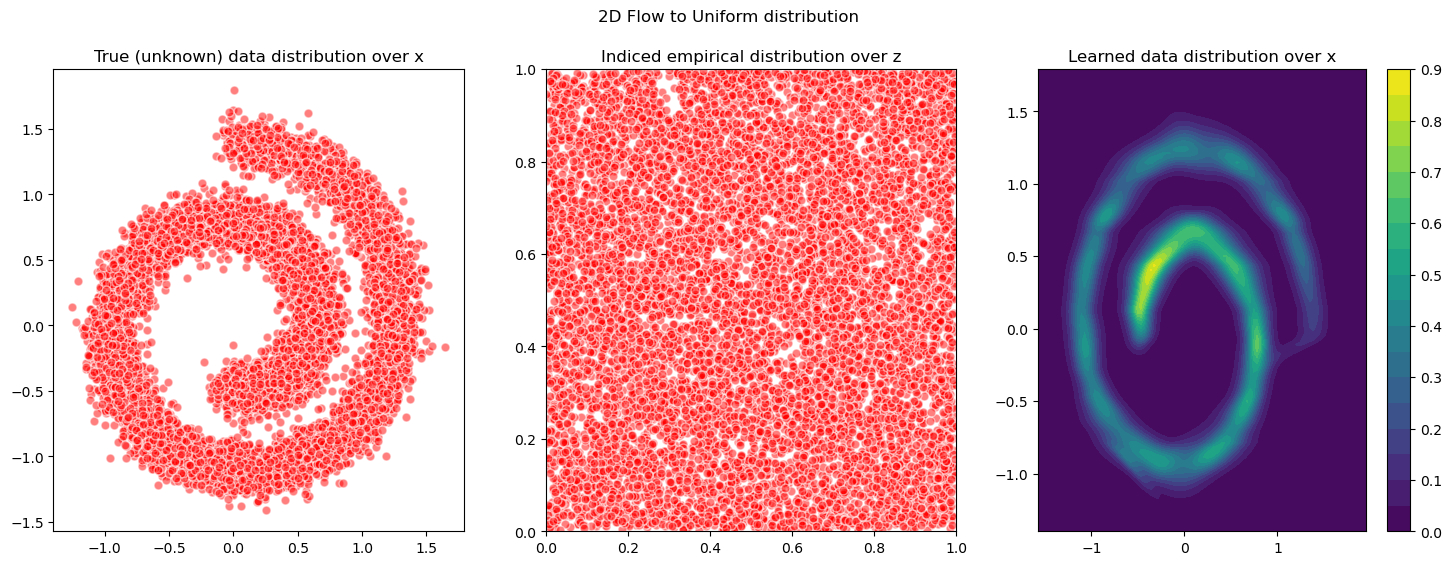

In [11]:
data = dataset.data.to(device)
_, (z1, z2) = model(dataset.data.to(device))
transformed_data = torch.cat([z1, z2], dim=1)
plot_results_flow_2D(data, transformed_data, model, device)

In [10]:
# Saving the model
torch.save(model, f'./weights/epoch_{NUM_EPOCHS}_FLOW2D.pth')